# Phase resolved spectroscopy of Type C QPO toy dataset

## Loading dataset

In [1]:
import astropy
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians, fit_crossspectrum
from scipy.stats import binned_statistic
from scipy.fftpack import fft, ifft

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
type_c = "./toy_TypeC_lightcurve.fits"

lc_fits = Table.read(type_c)
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
n_chans = meta['DETCHANS']
lc_fits
1/(n_seg*dt)

<Table length=8192>
name  dtype   shape   unit             description           
---- ------- ------- ------ ---------------------------------
 REF float64   (50,) ct / s       Reference band light curves
  CI float64 (5, 50) ct / s Channels of interest light curves
None
OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 50), ('NSECONDS', 64.0), ('INFILE', "['tlist_1.fits']"), ('OBJECT', 'GX_339-4')])


2.56

In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
print(ref.shape, ci.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape)

(50, 8192) (50, 5, 8192)
(409600,) (5, 409600)


## Plotting light curve and averaged power spectrum of reference band

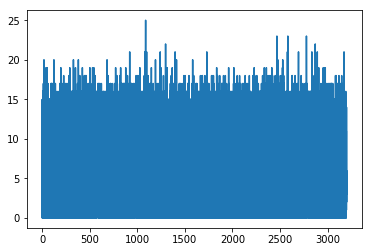

In [4]:
# rearranging reference band segments
ref_counts = np.hstack(ref)
ref_times = np.arange(0, n_seconds*n_seg, dt)

# plotting reference band lightcurve
ref_lc = Lightcurve(ref_times, ref_counts, dt=dt)
ref_lc.plot()

In [5]:
# plotting power spectrum of reference band
ref_aps = AveragedPowerspectrum(ref_lc, norm='leahy',segment_size=n_seg) # absolute normalisation

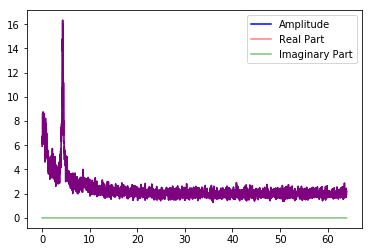

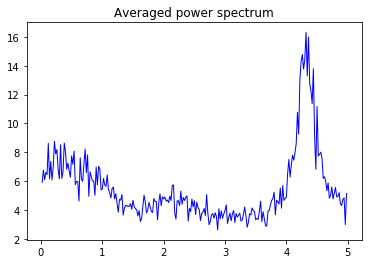

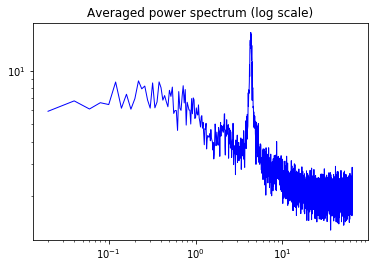

In [6]:
n = len(ref_aps.freq)
range_start, range_stop = int(0*n/64), int(5*n/64)

ref_aps.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')

plt.figure()
plt.title("Averaged power spectrum (log scale)")
plt.loglog(ref_aps.freq, np.abs(ref_aps.power), lw=1, color='blue')

## Fitting Lorentzian models
1. Two lorentzians (one for each component)
2. 1 Power Law (soft?)
3. Constant

[10.66799947  4.33968814  0.43940646  0.48296445  8.74070806  0.59338499
  2.0961978   2.11042274  0.53774892  1.55921039]


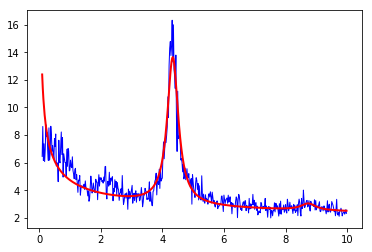

In [7]:
model_to_test = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps, model_to_test, fitmethod="CG")
res_model, res_pars = res.model, res.model.parameters

# print(res_model)
print(res_pars)

n = len(ref_aps.freq)
range_start, range_stop = int(0.1*n/64), int(10*n/64)

plt.figure()
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(res_model(ref_aps.freq))[range_start:range_stop], lw=2, color="red")

### Determining new N

In [8]:
def nearest_power_of_2(x):
    x = int(x)
    x_lower = 1 if x == 0 else 2**(x - 2).bit_length()
    x_upper = 1 if x == 0 else 2**(x - 1).bit_length()
    return x_lower if (x - x_lower) < (x_upper - x) else x_upper

In [9]:
fwhm = res_model[0].fwhm.value
new_n_bins = nearest_power_of_2(1/(fwhm*dt))
new_n_seg = int(n_bins*n_seg/new_n_bins)
print("current N:", n_bins)
print("new N:", new_n_bins)
print("current M:", n_seg)
print("new M:", new_n_seg)
n_bins/new_n_bins
df_old = 1/(n_bins*dt)
df_new = fwhm
dt_new = 1/(new_n_bins*df_new)
df_old, df_new, dt_new

current N: 8192
new N: 512
current M: 50
new M: 800


(0.015625, 0.43940646120685767, 0.004444916432579572)

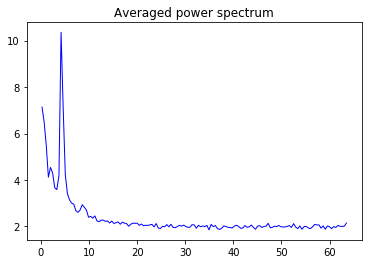

In [10]:
# plotting power spectrum of reference band
ref_aps_new = ref_aps.rebin(df=df_new)

n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(64*n/64)

# ref_aps_new.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps_new.freq[range_start:range_stop], (np.abs(ref_aps_new.power))[range_start:range_stop], lw=1, color='blue')


[9.26887739 4.33981927 0.55806575 0.47918212 8.76713447 0.83449767
 1.8953006  2.19154859 0.62555979 1.68267644]


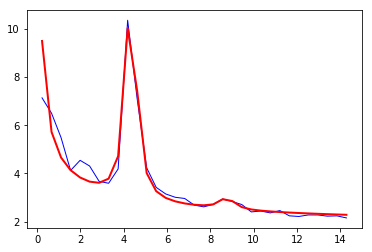

In [11]:
model_to_test = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps_new, model_to_test, fitmethod="CG")
res_model_new, res_pars_new = res.model, res.model.parameters
    
# print(res_model_new)
print(res_model_new.parameters)

n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(15*n/64)

plt.figure()
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(ref_aps_new.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(res_model_new(ref_aps_new.freq))[range_start:range_stop], lw=2, color="red")

In [12]:
def calculate_rms(ps, model):
    """ function to get fitting model used to calculate rms based on the type of filter used. """
    freq = ps.freq # replace this with self.freq later
    model_output = model(freq>=0) # paper: "the integral from zero to infinity of a Lorentzian component gives the squared rms in that component"
    df = freq[1]-freq[0]
    rms = np.sqrt(np.sum(model_output * df))
    return rms

In [13]:
avg_sigma_1 = calculate_rms(ref_aps_new, res_model_new[0]) # 1st harmonic Lorentzian
avg_sigma_2 = calculate_rms(ref_aps_new, res_model_new[1]) # 2nd harmonic Lorentzian
avg_sigma_1, avg_sigma_2

(2.0232648721726525, 0.2963985594846565)

### Phase Difference

In [14]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [15]:
x = ref_counts/dt
X = fft(x) # fourier transform of count rate

n = X.size
timestep = dt_new
ffreq = np.fft.fftfreq(n, d=timestep)

x_0_0 = res_model_new[0].x_0.value
x_0_1 = res_model_new[1].x_0.value

idx_0 = find_nearest_index(ffreq, x_0_0)
idx_1 = find_nearest_index(ffreq, x_0_1)

X_1 = X[idx_0] # 1st harmonic
X_2 = X[idx_1] # 2nd harmonic

small_psi_1 = np.angle(X_1)
small_psi_2 = np.angle(X_2)

cap_phi_1 = small_psi_1
cap_phi_2 = small_psi_2

In [16]:
small_psi = (cap_phi_2/2 - cap_phi_1) % np.pi

cap_phi_1, cap_phi_2, small_psi

(-0.2500909834960394, -3.0407255119057384, 1.8713208811329634)

In [17]:
# mean count rate
mu = np.mean(x)
mu

773.0115625

# QPO Waveform

In [18]:
def wave(x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2):
    y = mu * (1 + np.sqrt(2) * (avg_sigma_1 * np.cos(x - cap_phi_1) + avg_sigma_2 * np.cos(2*x - cap_phi_2)))
    return y

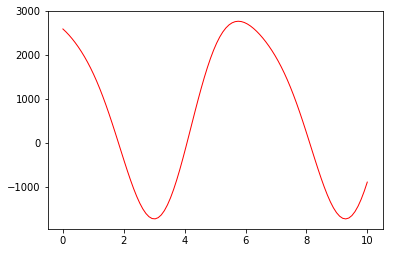

In [19]:
wave_x = np.linspace(0., 10., 100)
wave_y_avg = wave(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

plt.figure()
plt.plot(wave_x, wave_y_avg, lw=1, color='red')

# Calculating Error

In [20]:
ref_counts_seg = np.array_split(ref_counts, new_n_seg)

wave_ys = np.array([])

for i in range(new_n_seg): # for each segment
    # light curve and power spectrum
    ref_counts_seg_i = ref_counts_seg[i]
    ref_times_seg = np.arange(0, len(ref_counts_seg_i)*dt, dt)

    # plotting reference band lightcurve
    ref_lc_seg = Lightcurve(ref_times_seg, ref_counts_seg_i, dt=dt)
    ref_ps_seg = Powerspectrum(ref_lc_seg, norm='leahy')
    
    #calculating rms - reusing the model (as suggested in the paper)
    avg_sigma_1 = calculate_rms(ref_ps_seg, res_model_new[0]) # 1st harmonic Lorentzian
    avg_sigma_2 = calculate_rms(ref_ps_seg, res_model_new[1]) # 2nd harmonic Lorentzian
    
    # calculation of parameters
    x = ref_counts_seg_i/dt
    X = fft(x) # fourier transform of count rate

    n = X.size
    timestep = dt_new
    ffreq = np.fft.fftfreq(n, d=timestep)

    x_0_0 = res_model_new[0].x_0.value
    x_0_1 = res_model_new[1].x_0.value

    idx_0 = find_nearest_index(ffreq, x_0_0)
    idx_1 = find_nearest_index(ffreq, x_0_1)

    X_1 = X[idx_0]
    X_2 = X[idx_1]

    small_psi_1 = np.angle(X_1)
    small_psi_2 = np.angle(X_2)

    cap_phi_1 = small_psi_1
    cap_phi_2 = small_psi_2
    
    small_psi = (cap_phi_2/2 - cap_phi_1) % np.pi
    mu = np.mean(x)
    
    # waveform
    wave_y = wave(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

    if i == 0:
        wave_ys = np.hstack((wave_ys, np.array(wave_y)))
    else:
        wave_ys = np.vstack((wave_ys, np.array(wave_y)))

In [21]:
def standard_error(xs, mean):
    n_seg = len(xs)
    
    xs_diff_sq = np.subtract(xs, mean)**2
    standard_deviation = np.sum(xs_diff_sq, axis=0) / (n_seg-1)
    standard_error = np.sqrt(standard_deviation / n_seg)

    return standard_error

In [22]:
error = standard_error(wave_ys, wave_y)
error

array([98.46546639, 98.11822142, 96.93034524, 94.89104388, 92.02213208,
       88.38344936, 84.07919029, 79.26559494, 74.16018375, 69.05148876,
       64.3047199 , 60.35154071, 57.64346376, 56.55334443, 57.2507449 ,
       59.63170501, 63.36302132, 68.0018913 , 73.10537829, 78.28907277,
       83.2441879 , 87.73448773, 91.58709809, 94.68314284, 96.94983399,
       98.35400884, 98.89668999, 98.6082589 , 97.54395827, 95.7795636 ,
       93.4071617 , 90.53104   , 87.26373097, 83.72227388, 80.02475711,
       76.2871907 , 72.62073626, 69.12929421, 65.9074266 , 63.0385867 ,
       60.59364501, 58.62974512, 57.18957627, 56.30117411, 55.97831626,
       56.2214538 , 57.01895923, 58.3483649 , 60.1772844 , 62.4638511 ,
       65.15670338, 68.19470724, 71.50668327, 75.01139683, 78.61800912,
       82.22710748, 85.73236011, 89.02278385, 91.98557298, 94.50941203,
       96.48818027, 97.82495212, 98.4362038 , 98.25615656, 97.24122321,
       95.37458316, 92.67099717, 89.18208861, 85.00245119, 80.27